In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 1. Load the dataset

In [3]:
### if use google colab:
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive/AMLS_II_assignment21_22"
# os.chdir(path)
# print(os.getcwd())

In [4]:
### unzip training and test datasets.
# !apt-get install unzip
# !unzip ./Datasets/sentiment-analysis-on-movie-reviews/test.tsv.zip test.tsv
# !unzip ./Datasets/sentiment-analysis-on-movie-reviews/train.tsv.zip train.tsv

In [5]:
df = pd.read_csv('./Datasets/train.tsv', sep='\t')
df_test=pd.read_csv('./Datasets/test.tsv', sep='\t')
sample_submission = pd.read_csv('./Datasets/sampleSubmission.csv')

In [6]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
df.shape, df_test.shape

((156060, 4), (66292, 3))

# 2. Split into train(validation within it) and test

We can see that df_test's Sentiment/label is not available, thus we need to create our own test dataset for evaluation.

In [9]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 3) #test:train = 1:9

# 3. Data Analytics

## 3.1 Dataset overview

In [10]:
df_train.shape, df_test.shape

((140454, 4), (15606, 4))

In [11]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
151793,151794,8283,messy emotions,2
144411,144412,7840,"Man , Heart",2
116367,116368,6205,annoyed,1
37456,37457,1778,"its exquisite acting , inventive screenplay , ...",4
2961,2962,112,postcard,2


In [12]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
104526,104527,5516,bomb,0
135932,135933,7343,"as a bonus ,",2
150608,150609,8209,Even on its own ludicrous terms,2
62279,62280,3148,Quitting hits home with disorienting force .,3
109780,109781,5816,found writer-director Mitch Davis 's wall of k...,1


Above we can see that Phrase and Sentiment columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

## 3.2 Check if there is null/empty value

In [13]:
df_train.info(), df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140454 entries, 151793 to 71530
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    140454 non-null  int64 
 1   SentenceId  140454 non-null  int64 
 2   Phrase      140454 non-null  object
 3   Sentiment   140454 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.4+ MB


(None,
 PhraseId      0
 SentenceId    0
 Phrase        0
 Sentiment     0
 dtype: int64)

## 3.3 Class Distribution

The dataset looks good and we need to know how are distributed the 5 classes in the label so as to know it's balanced or not.

In [14]:
df_train.Sentiment.value_counts()

2    71624
3    29626
1    24545
4     8288
0     6371
Name: Sentiment, dtype: int64

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

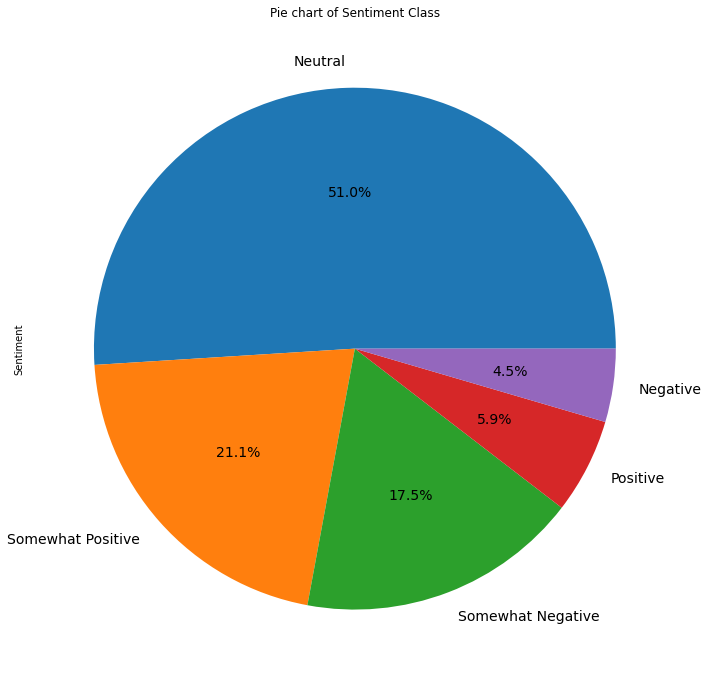

In [15]:
df2 = df_train.copy(deep = True) ## copy the dataset deeply
pie1 = pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat Negative').replace(2,'Neutral').replace(3,'Somewhat Positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace = True)
pie1.plot(kind = 'pie', title = 'Pie chart of Sentiment Class',y = 'Sentiment',
          autopct = '%1.1f%%', shadow = False, labels = pie1['index'], legend = False, fontsize = 14, figsize = (12,12))

The label is considerably unbalanced, only 'Neutral' corresponds to more than 50% of instances and there is a slightly skewed towards positive reviews. Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

## 3.4 No.words Distribution

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

In [16]:
# df_train[df_train['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x))

Text(0.5, 0.98, 'Histogram number of words in reviews')

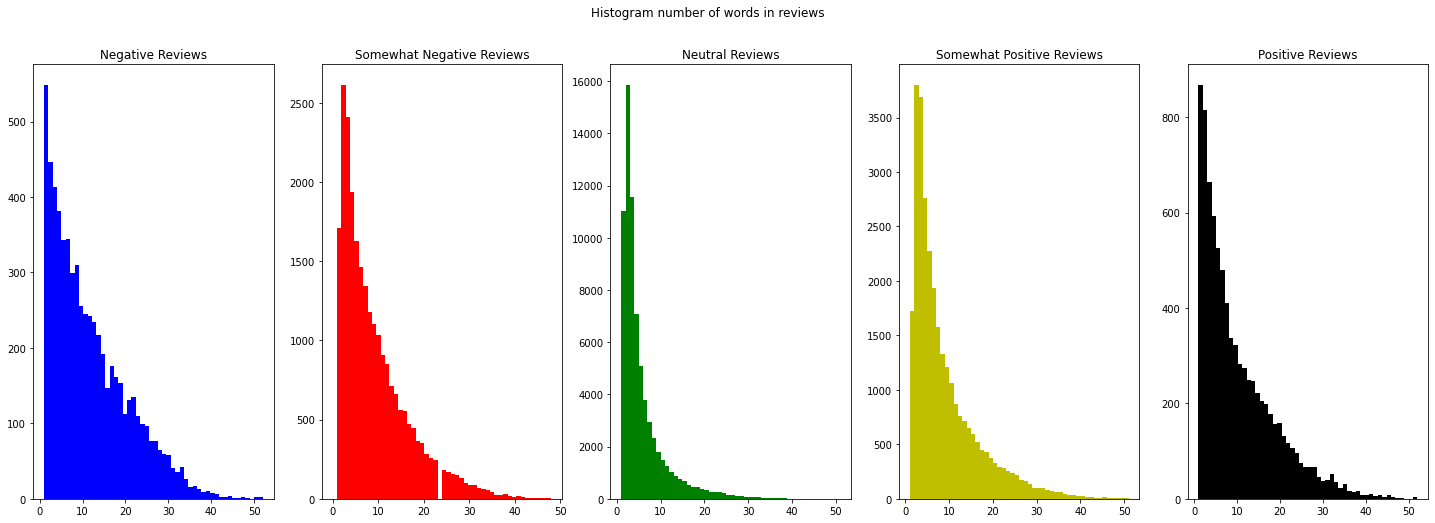

In [17]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df_train[df_train['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df_train[df_train['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df_train[df_train['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df_train[df_train['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df_train[df_train['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significantly as the x-axis increases. It seems like the longest sentence in Phrase column corresponds to a class 'Negative Reviews' and is around 52 words, now let's obtain the longest one by using the max() function:

In [18]:
df_train['Phrase'].str.split().map(lambda x: len(x)).max()

52

Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [19]:
df20=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', df20.loc[df20['Phrase']==True].shape[0])
print(' ')
df30=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', df30.loc[df30['Phrase']==True].shape[0])
print(' ')
df40=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', df40.loc[df40['Phrase']==True].shape[0])
print(' ')
df50=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', df50.loc[df50['Phrase']==True].shape[0])
print(' ')
df52=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', df52.loc[df52['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  10311
 
Number of sentences which contain more than 30 words:  2315
 
Number of sentences which contain more than 40 words:  316
 
Number of sentences which contain more than 50 words:  16
 
Number of sentences which contain 52 words:  3
 


Above we see 316 reviews contain more than 40 words and only 16 reviews above 50 words, these two number corresponds to a tiny proportion of the total number of instances (140,454), therefore setting to these numbers will not affect too much the classification. Below we can see an example of a sentence containing 52 words, observe there are misspelled words, acronyms and some of them can be decomposed into sub-words:

In [20]:
print(df_train.loc[87835,'Phrase'])

There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .


# 4. Preparation

## 4.1 Install transformers and import tensorflow.keras

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [21]:
# !pip install transformers

Then what we need from tensorflow.keras:

In [22]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

## 4.2 Extract useful features and labels

Now we have to gather from the dataset only the two columns useful for training (Phrase and Sentiment):

In [23]:
data = df_train[['Phrase', 'Sentiment']]
data = data.copy()

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

C:\Users\12151\AppData\Local\Temp\ipykernel_22664\115150731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
C:\Users\12151\AppData\Local\Temp\ipykernel_22664\115150731.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment'] = data['Sentiment_label'].cat.codes


In [24]:
data

,Phrase,Sentiment,Sentiment_label
151793,messy emotions,2,2
144411,"Man , Heart",2,2
116367,annoyed,1,1
37456,"its exquisite acting , inventive screenplay , ...",4,4
2961,postcard,2,2
...,...,...,...
11261,the years,2,2
104704,best sequel,4,4
48056,the last 100 years,2,2
77049,in which murder is casual and fun,2,2


## 4.3 Split the training set into training and validation dataset

Split into train and validation set, as the file contains more than 140 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [25]:
data_train, data_val = train_test_split(data, test_size = 0.1, random_state = 1)

# 5. Bert

## 5.1 Model Setups

As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model.

In [26]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

The model we will use is 'bert_base_uncased' and the max_length chosen is 45 as there are only a very small number of larger sequences.

In [27]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
# bert(inputs)
# TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 45, 768) dtype=float32 (created by layer 'bert')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
# why bert(inputs)[1], my understanding is our task is classification, so we need to choose pooler_output for classification
# BertPooler层主要是为了提取句子的第一个token作为[CLS]，是一个可选部分，只针对分类任务。

## 5.2 Build the Model

Now that our model has been loaded we can start the processes of building and tuning according to our dataset and task using the functional API of keras.

As we see below the input layer must consider the max_length of sequences and then this is fed to the bert model, a dropout layer to reduce overfitting (0.1) and finally a dense layer with number of neurons equal to number of classes in our label (5).

In [31]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1] # inputs --> bert(with pooler_output for classification)
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output') # dropout probability for all fully connected layers, defaults to 0.1
pooled_output = dropout(bert_model, training=False) # bert --> Dropout

# Then build your model output
# Output Layer: Dense with units = 5 connected to pooled_output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output) # Dropout --> Dense(Output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "BERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


## 5.3 Train the Model

In [27]:
# Callback
from keras import callbacks

### Custom callback to save logs for drawing training curves.
class LossAndAccHistory(callbacks.Callback):  # Inherited from the Callback class

    '''
    Define four attributes at the beginning of the model,
    each attribute is a dictionary type, storing the corresponding value and epoch
    '''

    def on_train_begin(self, logs={}):
        self.loss = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_accuracy = {'batch': [], 'epoch': []}

    # Record the corresponding value after each batch
    def on_batch_end(self, batch, logs={}):
        self.loss['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))

    # Record the corresponding value after each epoch
    def on_epoch_end(self, batch, logs={}):
        self.loss['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_accuracy['batch'].append(logs.get('val_accuracy'))

history = LossAndAccHistory()

In [31]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
epoch = 2
batch_size = 32
model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size = batch_size,
    epochs = epoch,
    verbose=1,
    callbacks= [history])

Epoch 1/2
3951/3951 [==============================] - 1094s 274ms/step - loss: 0.8061 - accuracy: 0.6677 - val_loss: 0.7600 - val_accuracy: 0.6776
Epoch 2/2
3951/3951 [==============================] - 1088s 275ms/step - loss: 0.7212 - accuracy: 0.7013 - val_loss: 0.7436 - val_accuracy: 0.6846


The model took 36 minutes and 22 seconds to train for 2 epochs.

## 5.4 Save the trained model and logs

In [32]:
model.save('./model_trained/bert_epoch{}_batch{}.h5'.format(epoch, batch_size))

In [ ]:
# from keras.models import load_model
# reconstructed_model = load_model("./model_trained/bert.h5")

In [33]:
np.save('./model_logs/bert_epoch{}_batch{}_train_acc.npy'.format(epoch, batch_size), history.accuracy['batch'])
np.save('./model_logs/bert_epoch{}_batch{}_train_loss.npy'.format(epoch, batch_size), history.loss['batch'])

In [ ]:
# RoBerta_train_acc = np.load('./model_logs/RoBerta.npy', allow_pickle=True)

## 5.5 Plot the training accuracy and loss

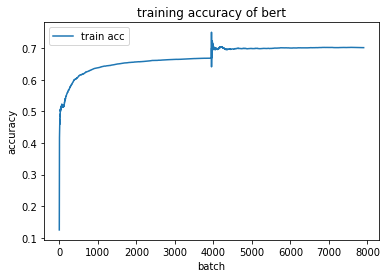

In [34]:
plt.plot(history.accuracy['batch'])
plt.title('training accuracy of bert')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train acc'], loc='upper left')
plt.show()

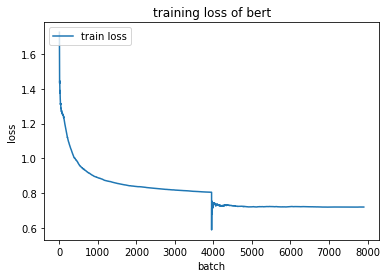

In [35]:
plt.plot(history.loss['batch'])
plt.title('training loss of bert')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train loss'], loc='upper left')
plt.show()

## 5.6 Inference on test dataset

In [35]:
from keras.models import load_model
model.load_weights('./model_trained/bert_epoch2_batch32.h5')
# model_load = load_model('./model_trained/bert_epoch2_batch32.h5')
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [36]:
label_predicted['Sentiment']

array([[ 0.11406317,  1.9848564 ,  2.0625584 , -0.7492176 , -2.90676   ],
       [-3.165531  , -0.8527772 ,  3.032676  ,  3.0113778 , -0.33053118],
       [-0.18876575,  2.2003057 ,  1.6924309 , -0.84037566, -3.2862709 ],
       ...,
       [-2.6975887 , -2.156398  ,  0.44640523,  3.1114585 ,  2.5921056 ],
       [-2.5360348 , -0.6209457 ,  1.436572  ,  2.6857522 ,  0.46509486],
       [-2.489567  , -2.0762122 ,  0.04212592,  2.8088543 ,  2.9336677 ]],
      dtype=float32)

In [37]:
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]


### Submission with pre-trained model:

In [42]:
submission = df_test[['PhraseId', 'Sentiment']]

In [43]:
submission['Sentiment_bert'] = label_pred_max
submission.head(10)

C:\Users\12151\AppData\Local\Temp\ipykernel_22664\2294642998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Sentiment_bert'] = label_pred_max


,PhraseId,Sentiment,Sentiment_bert
104526,104527,0,2
135932,135933,2,2
150608,150609,2,1
62279,62280,3,1
109780,109781,1,1
31031,31032,3,4
102471,102472,2,2
79882,79883,3,3
97764,97765,2,2
62321,62322,1,1


## 5.6 Evaluate on test dataset

We will compute the error metrics on the validation set in order to have an idea of the model performance.

In [36]:
# model_eval = model.evaluate(
#     x={'input_ids': x_val['input_ids']},
#     y={'Sentiment': y_val}
# )

In [37]:
# y_val_predicted = model.predict(
#     x={'input_ids': x_val['input_ids']},
# )

In [38]:
# y_val_predicted['Sentiment']

In [39]:
# y_val

In [40]:
# y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [41]:
# y_val_actual_max=[np.argmax(i) for i in y_val]

In [42]:
# from sklearn.metrics import classification_report
#
# report = classification_report(y_val_pred_max, y_val_actual_max)
#
# print(report)

In [43]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
# disp.plot(cmap='Blues')
# plt.grid(False)

In [ ]:
import keras.backend as K
import gc
del model
gc.collect()
K.clear_session()

# 6. RoBERTa

In [45]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig

In [46]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 40

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [47]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


In [33]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
epoch = 2
batch_size = 32
model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size= batch_size,
    epochs = epoch,
    verbose=1,
    callbacks=[history])

Epoch 1/2
3951/3951 [==============================] - 942s 236ms/step - loss: 0.8222 - accuracy: 0.6607 - val_loss: 0.7641 - val_accuracy: 0.6745
Epoch 2/2
3951/3951 [==============================] - 922s 233ms/step - loss: 0.7384 - accuracy: 0.6935 - val_loss: 0.7483 - val_accuracy: 0.6810


The model took 31 minutes and 4 seconds to train for 2 epochs.

In [34]:
model2.save('./model_trained/RoBERTa_epoch{}_batch{}.h5'.format(epoch, batch_size))
# from keras.models import load_model
# reconstructed_model = load_model("./model_trained/bert.h5")
np.save('./model_logs/RoBERTa_epoch{}_batch{}_train_acc.npy'.format(epoch, batch_size), history.accuracy['batch'])
np.save('./model_logs/RoBERTa_epoch{}_batch{}_train_loss.npy'.format(epoch, batch_size), history.loss['batch'])
# RoBerta_train_acc = np.load('./model_logs/RoBerta.npy', allow_pickle=True)

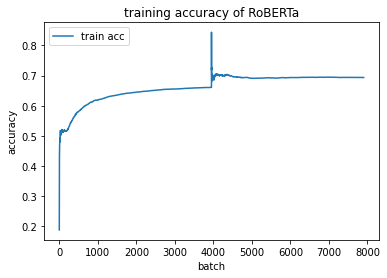

In [35]:
plt.plot(history.accuracy['batch'])
plt.title('training accuracy of RoBERTa')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train acc'], loc='upper left')
plt.show()

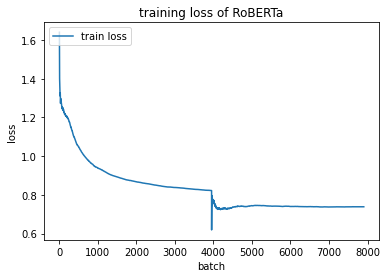

In [36]:
plt.plot(history.loss['batch'])
plt.title('training loss of RoBERTa')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [48]:
model2.load_weights('./model_trained/RoBERTa_epoch2_batch32.h5')
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
label_predicted = model2.predict(
    x={'input_ids': x_test['input_ids']},
)
# label_predicted['Sentiment']
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]
submission['Sentiment_RoBERTa'] = label_pred_max
submission.head(10)

,PhraseId,Sentiment,Sentiment_bert,Sentiment_RoBERTa
104526,104527,0,2,2
135932,135933,2,2,2
150608,150609,2,1,1
62279,62280,3,1,3
109780,109781,1,1,1
31031,31032,3,4,4
102471,102472,2,2,2
79882,79883,3,3,3
97764,97765,2,2,2
62321,62322,1,1,1


In [49]:
del model2
gc.collect()
K.clear_session()

# 7. DistilBERT

In [51]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 

In [52]:
### --------- Setup DistilBERT ---------- ###

model_name = 'distilbert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Distilbert model
transformer_distilbert_model = TFDistilBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [53]:
### ------- Build the model ------- ###

# Load the MainLayer
distilbert = transformer_distilbert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers DistilBERT model as a layer in a Keras model
distilbert_model = distilbert(inputs)[0][:,0,:]
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(distilbert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model3 = Model(inputs=inputs, outputs=outputs, name='DistilBERT_MultiClass')

# Take a look at the model
model3.summary()

Model: "DistilBERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 66,366,725
Trainable params: 66,366,725
Non-trainable params: 0
_________________________________________________________________


In [35]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model3.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
epoch = 2
batch_size = 32
model3.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=batch_size,
    epochs=epoch,
    verbose=1,
    callbacks= [history])

Epoch 1/2
3951/3951 [==============================] - 536s 134ms/step - loss: 0.8280 - accuracy: 0.6586 - val_loss: 0.7841 - val_accuracy: 0.6742
Epoch 2/2
3951/3951 [==============================] - 532s 135ms/step - loss: 0.7574 - accuracy: 0.6868 - val_loss: 0.7779 - val_accuracy: 0.6759


The model took 17 minutes and 48 seconds to train for 2 epochs.

In [36]:
model3.save('./model_trained/DistilBERT_epoch{}_batch{}.h5'.format(epoch, batch_size))
# from keras.models import load_model
# reconstructed_model = load_model("./model_trained/bert.h5")
np.save('./model_logs/DistilBERT_epoch{}_batch{}_train_acc.npy'.format(epoch, batch_size), history.accuracy['batch'])
np.save('./model_logs/DistilBERT_epoch{}_batch{}_train_loss.npy'.format(epoch, batch_size), history.loss['batch'])
# RoBerta_train_acc = np.load('./model_logs/RoBerta.npy', allow_pickle=True)

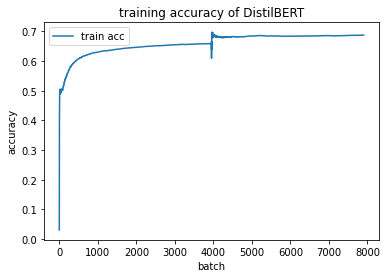

In [37]:
plt.plot(history.accuracy['batch'])
plt.title('training accuracy of DistilBERT')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train acc'], loc='upper left')
plt.show()

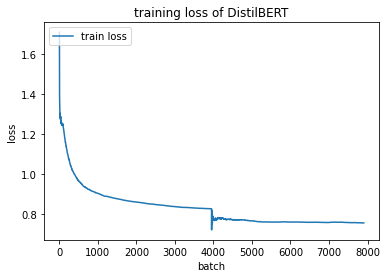

In [38]:
plt.plot(history.loss['batch'])
plt.title('training loss of DistilBERT')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [54]:
model3.load_weights('./model_trained/DistilBERT_epoch2_batch32.h5')
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
label_predicted = model3.predict(
    x={'input_ids': x_test['input_ids']},
)
# label_predicted['Sentiment']
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]
submission['Sentiment_DistilBERT'] = label_pred_max
submission.head(10)

,PhraseId,Sentiment,Sentiment_bert,Sentiment_RoBERTa,Sentiment_DistilBERT
104526,104527,0,2,2,2
135932,135933,2,2,2,2
150608,150609,2,1,1,2
62279,62280,3,1,3,1
109780,109781,1,1,1,1
31031,31032,3,4,4,3
102471,102472,2,2,2,1
79882,79883,3,3,3,3
97764,97765,2,2,2,2
62321,62322,1,1,1,1


In [55]:
del model3
gc.collect()
K.clear_session()

# 8. XLNet

In [31]:
# !pip install sentencepiece

In [56]:
from transformers import XLNetTokenizer, TFXLNetModel, XLNetConfig
import sentencepiece

In [57]:
### --------- Setup XLNet ---------- ###

model_name = 'xlnet-base-cased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = XLNetConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the XLNet model
transformer_xlnet_model = TFXLNetModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [58]:
### ------- Build the model ------- ###

# Load the MainLayer
xlnet = transformer_xlnet_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers XLNet model as a layer in a Keras model
xlnet_model = xlnet(inputs)[0]
xlnet_model = tf.squeeze(xlnet_model[:, -1:, :], axis=1)
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(xlnet_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model4 = Model(inputs=inputs, outputs=outputs, name='XLNet_MultiClass')

# Take a look at the model
model4.summary()

Model: "XLNet_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
transformer (TFXLNetMainLaye TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 116,722,181
Trainable params: 116,722,181
Non-trainable params: 0
____________________________________

In [31]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model4.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
epoch = 2
batch_size = 32
model4.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=batch_size,
    epochs=epoch,
    verbose=1,
    callbacks= [history])

Epoch 1/2
3951/3951 [==============================] - 1115s 280ms/step - loss: 0.8024 - accuracy: 0.6664 - val_loss: 0.7646 - val_accuracy: 0.6751
Epoch 2/2
3951/3951 [==============================] - 1113s 282ms/step - loss: 0.7290 - accuracy: 0.6964 - val_loss: 0.7566 - val_accuracy: 0.6783


The model took 37 minutes and 8 seconds to train for 2 epochs.

In [32]:
model4.save('./model_trained/XLNet_epoch{}_batch{}.h5'.format(epoch, batch_size))
# from keras.models import load_model
# reconstructed_model = load_model("./model_trained/bert.h5")
np.save('./model_logs/XLNet_epoch{}_batch{}_train_acc.npy'.format(epoch, batch_size), history.accuracy['batch'])
np.save('./model_logs/XLNet_epoch{}_batch{}_train_loss.npy'.format(epoch, batch_size), history.loss['batch'])
# RoBerta_train_acc = np.load('./model_logs/RoBerta.npy', allow_pickle=True)

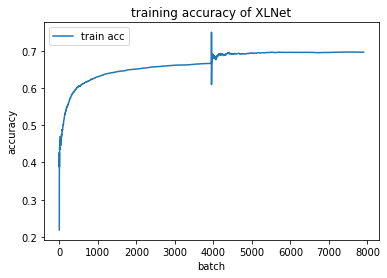

In [33]:
plt.plot(history.accuracy['batch'])
plt.title('training accuracy of XLNet')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train acc'], loc='upper left')
plt.show()

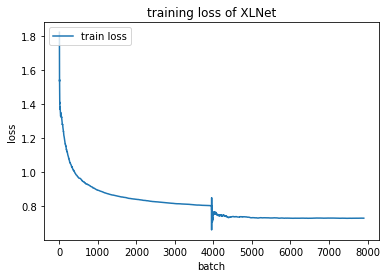

In [34]:
plt.plot(history.loss['batch'])
plt.title('training loss of XLNet')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train loss'], loc='upper left')
plt.show()

In [59]:
model4.load_weights('./model_trained/XLNet_epoch2_batch32.h5')
x_test = tokenizer(
          text=df_test['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True,
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)
label_predicted = model4.predict(
    x={'input_ids': x_test['input_ids']},
)
# label_predicted['Sentiment']
label_pred_max=[np.argmax(i) for i in label_predicted['Sentiment']]
submission['Sentiment_XLNet'] = label_pred_max
submission.head(10)

,PhraseId,Sentiment,Sentiment_bert,Sentiment_RoBERTa,Sentiment_DistilBERT,Sentiment_XLNet
104526,104527,0,2,2,2,2
135932,135933,2,2,2,2,2
150608,150609,2,1,1,2,1
62279,62280,3,1,3,1,2
109780,109781,1,1,1,1,1
31031,31032,3,4,4,3,4
102471,102472,2,2,2,1,2
79882,79883,3,3,3,3,3
97764,97765,2,2,2,2,2
62321,62322,1,1,1,1,1


In [60]:
del model4
gc.collect()
K.clear_session()

In [63]:
submission.to_csv("./submission/submission.csv", index=False, header=True)
print('Submission is ready!')

Submission is ready!
